In [ ]:
!pip install transformers==2.6.0

In [ ]:
!pip install fairseq

In [ ]:

!pip install fastBPE

In [ ]:
!pip install seqeval

In [ ]:
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import transformers
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler
from torch.nn import CrossEntropyLoss

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

from transformers import RobertaConfig, RobertaForTokenClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from seqeval.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MAX_LEN = 256
batch_sz = 16
epochs = 5
max_grad_norm = 1.0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('{}: {}'.format(device, n_gpu))

cuda: 1


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/data/DataNer.txt", sep=" ", header=None, skip_blank_lines=False, encoding="utf-8")
data.columns = ["word","pos", "upper", "number","tag"]
# data[1:11]

In [ ]:
def isNaN(string):
    return string != string
print(isNaN("nan"))


False


In [ ]:
print(isNaN(data['word'][10]))

True


In [ ]:

sentences_with_tag = []
sentence_with_tag = []
for w,t in zip(data['word'].values, data['tag'].values):
  if isNaN(w)==False:
    sentence_with_tag.append((w,t))
  if isNaN(w)==True: 
    sentences_with_tag.append(sentence_with_tag)
    sentence_with_tag = []
sentences_with_tag

[[('cho', 'O'),
  ('em', 'O'),
  ('hỏi', 'O'),
  ('placement', 'O'),
  ('test', 'O'),
  ('thi', 'O'),
  ('những', 'O'),
  ('nôi', 'O'),
  ('dung', 'O'),
  ('nào', 'O')],
 [('placement', 'O'),
  ('test', 'O'),
  ('có', 'O'),
  ('mấy', 'O'),
  ('phần', 'O'),
  ('tất_cả', 'O'),
  ('ạ', 'O')],
 [('Trong', 'O'),
  ('bài', 'O'),
  ('thi', 'O'),
  ('tiếng', 'B-Subject_Name'),
  ('anh', 'I-Subject_Name'),
  ('kỹ_năng', 'O'),
  ('nói', 'O'),
  ('chiếm', 'O'),
  ('bao_nhiêu', 'O'),
  ('điểm', 'O'),
  ('ạ', 'O'),
  ('?', 'O')],
 [('thời_gian', 'O'),
  ('cho', 'O'),
  ('kỹ_năng', 'O'),
  ('nói', 'O'),
  ('là', 'O'),
  ('bao_lâu', 'O'),
  ('ạ', 'O')],
 [('hình_thức', 'O'),
  ('thi', 'O'),
  ('tiếng', 'B-Subject_Name'),
  ('anh', 'I-Subject_Name'),
  ('là', 'O'),
  ('gì', 'O'),
  ('ạ', 'O')],
 [('cho', 'O'),
  ('em', 'O'),
  ('hỏi', 'O'),
  ('thi', 'O'),
  ('tiếng', 'B-Subject_Name'),
  ('anh', 'I-Subject_Name'),
  ('thi', 'O'),
  ('theo', 'O'),
  ('hình_thức', 'O'),
  ('nào', 'O')],
 [('thi', 'O'),

In [ ]:
sentences = [' '.join([word[0] for word in sent]) for sent in sentences_with_tag]
sentences[2593]

'Ad ơi ngành qtks bây_giờ còn slot nào k ạ ?'

In [ ]:
labels = [[word[1] for word in sent] for sent in sentences_with_tag]
labels[2]

['O',
 'O',
 'O',
 'B-Subject_Name',
 'I-Subject_Name',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
classes = list(filter(lambda x: x not in ["O", np.nan], list(data["tag"].unique())))
classes

['B-Subject_Name',
 'I-Subject_Name',
 'B-number',
 'B-datetime',
 'I-datetime',
 'B-Uni_Name',
 'I-Uni_Name',
 'B-Campus_Name',
 'I-Campus_Name',
 'B-Major_Name',
 'I-Major_Name',
 'B-Teacher_Name',
 'I-Teacher_Name',
 'B-Dept_Name',
 'I-Dept_Name',
 'B-Major_Mode',
 'I-Major_Mode',
 'B-duration',
 'I-duration',
 'B-Admission_Type',
 'I-Admission_Type',
 'B-Docs_Name',
 'I-Docs_Name',
 'B-Scholar_Name',
 'I-Scholar_Name',
 'B-K_years',
 'I-K_years',
 'B-location',
 'I-number']

In [ ]:
labels_value = classes

In [ ]:
labels_value.append('O')
labels_value.append('PAD')
labels_value.append('[CLS]')
labels_value.append('[SEP]')
labels_value.append('X')


In [ ]:
label2idx = {label:indx for indx, label in enumerate(labels_value)}
label2idx

{'B-Admission_Type': 19,
 'B-Campus_Name': 7,
 'B-Dept_Name': 13,
 'B-Docs_Name': 21,
 'B-K_years': 25,
 'B-Major_Mode': 15,
 'B-Major_Name': 9,
 'B-Scholar_Name': 23,
 'B-Subject_Name': 0,
 'B-Teacher_Name': 11,
 'B-Uni_Name': 5,
 'B-datetime': 3,
 'B-duration': 17,
 'B-location': 27,
 'B-number': 2,
 'I-Admission_Type': 20,
 'I-Campus_Name': 8,
 'I-Dept_Name': 14,
 'I-Docs_Name': 22,
 'I-K_years': 26,
 'I-Major_Mode': 16,
 'I-Major_Name': 10,
 'I-Scholar_Name': 24,
 'I-Subject_Name': 1,
 'I-Teacher_Name': 12,
 'I-Uni_Name': 6,
 'I-datetime': 4,
 'I-duration': 18,
 'I-number': 28,
 'O': 29,
 'PAD': 30,
 'X': 33,
 '[CLS]': 31,
 '[SEP]': 32}

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/My Drive/Colab Notebooks/NLP/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,  
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()

bpe = fastBPE(args)

In [ ]:
subwords = ['<s> '+bpe.encode(sent)+' </s>' for sent in sentences]
subwords[2593]

'<s> A@@ d ơi ngành q@@ t@@ ks bây_giờ còn s@@ lot nào k ạ ? </s>'

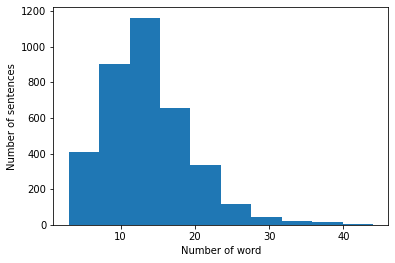

In [ ]:
plt.hist([len(s.split()) for s in subwords])
plt.xlabel('Number of word')
plt.ylabel('Number of sentences')
plt.show()

In [ ]:
label_subwords = []
for i in range(len(subwords)):
  indx = 0
  label = ['[CLS]']
  for word in subwords[i].split()[1:MAX_LEN-1]:
    if word == '</s>':
      break
    if '@@' not in word:
      label.append(labels[i][indx])
      indx += 1
      continue
    label.append('X')
  label.append('[SEP]')
  label_subwords.append(label)

In [ ]:
label_subwords[3659]


['[CLS]',
 'B-Scholar_Name',
 'I-Scholar_Name',
 'I-Scholar_Name',
 'O',
 'O',
 'O',
 'O',
 '[SEP]']

In [ ]:
vocab = Dictionary()
vocab.add_from_file("/content/drive/My Drive/Colab Notebooks/NLP/PhoBERT_base_transformers/dict.txt")

In [ ]:
input_ids = pad_sequences([vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist() for sent in subwords],
                          truncating='post', padding='post', maxlen=MAX_LEN, value=1.0, dtype='long')

In [ ]:
input_ids[3659]

array([    0,  3431,   227, 12284,     8,  1398,  3628,   114,     2,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,

In [ ]:
labels_ids = pad_sequences([[label2idx.get(label) for label in labels] for labels in label_subwords],
                            maxlen=MAX_LEN, value=label2idx['PAD'], truncating='post', padding='post', dtype='long')
labels_ids[1]


array([31, 33, 33, 29, 29, 29, 29, 29, 29, 29, 32, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30

In [ ]:
attenion_mask = [[float(val != 1) for val in sent] for sent in input_ids]

In [ ]:
X_test = input_ids[3290:]
y_test = labels_ids[3290:]
test_mask = attenion_mask[3290:]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids[:3290], labels_ids[:3290], random_state=96, test_size=0.1)
train_mask, val_mask, _, _ = train_test_split(attenion_mask[:3290], input_ids[:3290], random_state=96, test_size=0.1)

In [ ]:

# change to tensor
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)
train_mask = torch.tensor(train_mask)
val_mask = torch.tensor(val_mask)
test_mask = torch.tensor(test_mask)

In [ ]:
#create data loader
train_data = TensorDataset(X_train, train_mask, y_train)
train_sample = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sample, batch_size=batch_sz)

val_data = TensorDataset(X_val, val_mask, y_val)
val_sample = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sample, batch_size=batch_sz)

test_data = TensorDataset(X_test, test_mask, y_test)
test_sample = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sample, batch_size=batch_sz)

In [ ]:
test_data[1]

(tensor([    0,   100,  1494, 13863,  3531,     7,  2795,  2433,   255, 35147,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [ ]:
from transformers import *

class Ner(BertPreTrainedModel):
   config_class = RobertaConfig
   pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
   base_model_prefix = "roberta"
   def __init__(self, config):
       super().__init__(config)
       self.num_labels = config.num_labels
       self.roberta = RobertaModel(config)
       self.dropout = nn.Dropout(config.hidden_dropout_prob)
       self.classifier = nn.Linear(config.hidden_size*4, config.num_labels)
       self.init_weights()

   def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

       outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
       
       output = torch.cat((outputs[2][-1],outputs[2][-2], outputs[2][-3], outputs[2][-4]), dim=-1)
       sequence_output = self.dropout(output)
       logits = self.classifier(sequence_output)
       outputs = logits

       if labels is not None:
        loss_fct = CrossEntropyLoss()
        active_loss = attention_mask.view(-1) == 1
        active_logits = logits.view(-1, self.num_labels)
        active_labels = torch.where(
                active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
        )
        loss = loss_fct(active_logits, active_labels)
        outputs = (loss, logits)
       return outputs

In [ ]:
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/Colab Notebooks/NLP/PhoBERT_base_transformers/config.json",
    num_labels=len(label2idx),
    output_hidden_states=True
)

In [ ]:
model = RobertaForTokenClassification.from_pretrained(
    "/content/drive/My Drive/Colab Notebooks/NLP/PhoBERT_base_transformers/model.bin",
    config=config
)

In [ ]:
model = Ner.from_pretrained(
    "/content/drive/My Drive/Colab Notebooks/NLP/PhoBERT_base_transformers/model.bin",
    config=config
)

In [ ]:
# pass model parameter to GPU
model.cuda()

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Ner(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwi

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:

total_steps = len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
for epoch in trange(epochs, desc='Epoch'):
  
  # TRAIN
  
  model.train()
  total_loss = 0
  for batch in train_dataloader:
    # add to GPU
    batch = tuple(t.to(device) for t in batch)
    X_train, train_mask, y_train = batch

    # clear gradient after each backward
    model.zero_grad()

    # get loss and score
    output = model(X_train, attention_mask=train_mask, labels=y_train)

    loss = output[0]
    loss.backward()

    total_loss += loss.item()
    
    # norm gradient
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    
    # update parameter
    optimizer.step()
    # update learning rate
    scheduler.step()
  
  print('Average train loss: {}'.format(total_loss/len(train_dataloader)))

  # VALIDATION

  model.eval()

  pred_labels_ids, true_labels_ids, val_ids_sent = [], [], []
  for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    X_val, val_mask, y_val = batch

    # return (score)
    with torch.no_grad():
      output_val = model(X_val, val_mask)
    
    # move to CPU
    val_ids_sent.extend(X_val)
    logit = output_val.detach().cpu().numpy()
    label_ids = y_val.to('cpu').numpy()

    pred_labels_ids.extend([list(pred_label) for pred_label in np.argmax(logit, axis=2)])
    true_labels_ids.extend(label_ids)
  
  # dont use PAD labels to compute f1 score
  pred_labels = [labels_value[pred_indx] for pred, true in zip(pred_labels_ids, true_labels_ids)
                                      for pred_indx, true_indx in zip(pred, true) if labels_value[true_indx] != 'PAD']
  true_labels = [labels_value[indx] for true in true_labels_ids
                                      for indx in true if labels_value[indx] != 'PAD']
  print('{}. Validation F1-score: {}\n'.format(epoch+1, f1_score(pred_labels, true_labels)))

/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.5735231862924192
1. Validation F1-score: 0.8973765432098766

Average train loss: 0.13845451716684126
2. Validation F1-score: 0.936006168080185

Average train loss: 0.07742859038364103
3. Validation F1-score: 0.943033102386451

Average train loss: 0.05374970030219805
4. Validation F1-score: 0.948905109489051

Average train loss: 0.04118017488915313
5. Validation F1-score: 0.9519045786841093




In [ ]:
pred_labels_ids, true_labels_ids, val_ids_sent = [], [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    X, mask, y = batch

    # return (score)
    with torch.no_grad():
      output_test = model(X, mask)
    
    # move to CPU
    val_ids_sent.extend(X)
    logit = output_test.detach().cpu().numpy()
    label_ids = y.to('cpu').numpy()

    pred_labels_ids.extend([list(pred_label) for pred_label in np.argmax(logit, axis=2)])
    true_labels_ids.extend(label_ids)
  
  # dont use PAD labels to compute f1 score
pred_labels = [labels_value[pred_indx] for pred, true in zip(pred_labels_ids, true_labels_ids)
                                      for pred_indx, true_indx in zip(pred, true) if labels_value[true_indx] != 'PAD']
true_labels = [labels_value[indx] for true in true_labels_ids
                                      for indx in true if labels_value[indx] != 'PAD']
print('Test F1-score: {}\n'.format(f1_score(pred_labels, true_labels)))

Test F1-score: 0.9550224887556221



In [ ]:
list(zip(true_labels, pred_labels))

[('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('B-Major_Name', 'B-Major_Name'),
 ('I-Major_Name', 'I-Major_Name'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('B-Major_Name', 'B-Major_Name'),
 ('I-Major_Name', 'I-Major_Name'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('B-Major_Name', 'B-Major_Name'),
 ('I-Major_Name', 'I-Major_Name'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('X', 'X'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('[SEP]', '[SEP]'),
 ('[CLS]', '[CLS]'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('O', 'O'),
 ('

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score
print(classification_report(true_labels, pred_labels))

                precision    recall  f1-score   support

      datetime       0.91      0.95      0.93        56
      Uni_Name       0.88      0.95      0.91        96
    Major_Name       0.88      0.90      0.89        62
             X       1.00      0.99      1.00       239
         [SEP]       1.00      1.00      1.00       370
  Scholar_Name       0.79      0.87      0.83        53
         [CLS]       1.00      1.00      1.00       370
        number       0.90      0.82      0.86        22
      duration       0.64      0.70      0.67        10
    Major_Mode       0.61      0.46      0.52        24
Admission_Type       0.50      1.00      0.67        12
  Subject_Name       0.00      0.00      0.00         6
     Docs_Name       0.33      0.50      0.40         2
       K_years       0.50      0.50      0.50         4

     micro avg       0.95      0.96      0.96      1326
     macro avg       0.95      0.96      0.95      1326



In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/NLP/models/model_phobert_NER.pt'
# labels_value = ['B-pr','I-pr','O', 'PAD', '[CLS]', '[SEP]', 'X']
# label2idx = {label:indx for indx, label in enumerate(labels_value)}

In [ ]:

torch.save(model.state_dict(),PATH)

In [ ]:
ner = model

In [ ]:
ner.load_state_dict(torch.load(PATH))
ner.eval()

Ner(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwi

In [ ]:
!pip install vncorenlp

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP('/content/drive/My Drive/Colab Notebooks/NLP/vncorenlp/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size='-Xmx500m') 

In [ ]:
test_sentence = 'kinh doanh qt điểm chúng tuyển bn ạ?'
tokenized_text = rdrsegmenter.tokenize(test_sentence)
text = []
text.append(' '.join(word for word in tokenized_text[0]))


In [ ]:
sent = '<s> ' + bpe.encode(text[0]) +' </s>'
sent_ids = vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist()

tokenized_sentence = pad_sequences([sent_ids], maxlen=MAX_LEN, dtype="long", value=1.0, truncating="post", padding="post")
input_ids = torch.tensor(tokenized_sentence)

mask = [[float(m != 1) for m in val] for val in input_ids]
mask = torch.tensor(mask)

with torch.no_grad():
    output = ner(input_ids.cuda(), mask.cuda())
label_ids = np.argmax(output[0].cpu().numpy(), axis=1)

In [ ]:
subword_label = list(zip([labels_value[label] for label in label_ids], sent.split()))
subword_label

[('[CLS]', '<s>'),
 ('B-Major_Name', 'kinh_doanh'),
 ('X', 'q@@'),
 ('I-Major_Name', 't'),
 ('O', 'điểm'),
 ('O', 'chúng'),
 ('O', 'tuyển'),
 ('X', 'b@@'),
 ('O', 'n'),
 ('O', 'ạ'),
 ('O', '?'),
 ('[SEP]', '</s>')]

In [ ]:
sentence = []
labels = []
word = ''
for label, sword in subword_label:
  if '@@' not in sword:
    word += sword
    sentence.append(word)
    labels.append(label)
    word = ''
    continue
  word += sword.replace('@@', '')

list(zip(sentence, labels))

[('<s>', '[CLS]'),
 ('kinh_doanh', 'B-Major_Name'),
 ('qt', 'I-Major_Name'),
 ('điểm', 'O'),
 ('chúng', 'O'),
 ('tuyển', 'O'),
 ('bn', 'O'),
 ('ạ', 'O'),
 ('?', 'O'),
 ('</s>', '[SEP]')]

In [ ]:
def unique(list1): 
  
    unique_list = [] 
    for x in list1: 
        if x not in unique_list: 
            unique_list.append(x) 
    for x in unique_list: 
        return x

In [ ]:
# Product perform by upper word
sentence2string = ''
i = 0
for word, label in list(zip(sentence, labels)):
  if label[0] == 'B':
    tag =[]
    sentence2string  = ''
    sentence2string += (word.upper() +' ')
    tag.append(label[2:])
  if label[0] == 'I':
    sentence2string += (word.upper() +' ')
  if label[0] == 'I' and labels[i+1][0] == 'O':
    print("{:15}: {:5}".format(sentence2string, unique(tag)))
  if label[0] == 'I' and labels[i+1][0] == 'B':
    print("{:15}: {:5}".format(sentence2string, unique(tag)))
  i = i+1  



KINH_DOANH QT  : Major_Name
